<a href="https://colab.research.google.com/github/afrojaakter/Deep-Reinforcement-Learning/blob/main/CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Install some visualization dependences for the agents
!apt-get-install -y xvfb python-opengl x11-until > /dev/null 2>&1
!pip install gym pyvirtualdisplay scikit-video > /dev/null 2>&1

%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import base64, io, time, gym
import IPython, functools
import matplotlib.pyplot as plt
from tqdm import tqdm

#Download and import MIT 6.S191 packages
!pip install mitdeeplearning
import mitdeeplearning as mdl


     |████████████████████████████████| 2.1MB 4.1MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-cp37-none-any.whl size=2115441 sha256=a1233eb9c3648aa8659b565b605157bd4c0532f0e4756b7a0e8afd2d07d7095d
  Stored in directory: /root/.cache/pip/wheels/af/dc/2a/5c3633135e7e4ef4fd31463cfa1942cb1bae7486ab94e7a2ad
Successfully built mitdeeplearning


In [13]:
#Instantiate the Cartpole environment
env = gym.make('CartPole-v0')
env.seed(1)

[1]

In [15]:
n_observations = env.observation_space
n_actions = env.action_space.n
print(n_observations, n_actions)

Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32) 2


#Cartpole agent

In [17]:
#Cartpole agent

#Define a feed-forward network
def create_cartpole_model():
  model = tf.keras.models.Sequential([
                                      tf.keras.layers.Dense(units=32, activation='relu'),
                                      tf.keras.layers.Dense(units=n_actions, activation=None)
  ])
  return model

cartploe_model = create_cartpole_model()


In [22]:
#Agent's action 
def choose_action(model, observation, single = True):
  """takes observation as input, excutes a forward pass through model
  and outputs a sampled action.
  Arguments::
  model: the network that defines agent
  observation: observations which are fed as input to the model
  single: flag as to whether we are handling a single observations or 
          a batch of observations.
  returns:: 
  action: choise of agent action
  """
  #add batch dimension to the observation if single example was provided
  observation = np.expand_dims(observation, axis=0) if single else observation
  
  logits = model.predict(observation) # predict the log probabilities of each possible action
  action = tf.random.categorical(logits, num_samples=1) #an action from the categorical distribution defined by the log probabilities of each possible action.
  action = action.numpy().flatten()
  return action[0] if single else action

#Agent's momory

In [31]:
class Memory:
  def __init__(self):
    self.clear()

  def clear(self):
    self.observations = []
    self.actions = []
    self.rewards = []
  
  def add_to_memory(self, new_observation, new_action, new_reward):
    self.observations.append(new_observation)
    self.actions.append(new_action)
    self.rewards.append(new_reward)
  
def aggregate_momories(memories):
  batch_memory = Memory()
  for memory in memories:
    for step in zip(memory.observations, memory.actions, memory.rewards):
      batch_memory.add_to_memory(*step)
  return batch_memory

memory = Memory()

#Reward Function

In [33]:
def normalize(x):
  x -= np.mean(x)
  x/= np.std(x)
  return x.astype(np.float32)

def discount_rewards(rewards, gamma = 0.95):
  discounted_rewards =  np.zeros_like(rewards)
  R = 0
  for t in reversed(range(0, len(rewards))):
    R = R * gamma + rewards[t]
    discounted_rewards[t] = R
  return normalize(discounted_rewards)


#Learning Algorithm

In [25]:
#Loss function

def compute_loss(logits, actions, rewards):
  neg_legprob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=actions)
  loss = tf.reduce_mean(neg_legprob * rewards)
  return loss

In [26]:
def train_step(model, optimizer, observations, actions, discount_rewards):
  with tf.GradientTape() as tape:
    #forward propagate through the agent network
    logits = model(observations)
    loss = compute_loss(logits, actions, discount_rewards)

  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

#Run CartPole

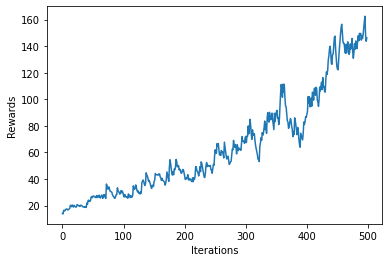

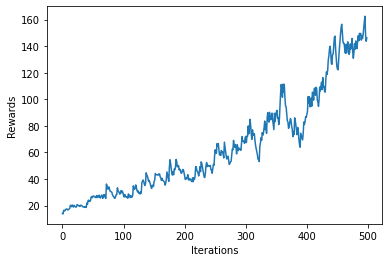

In [34]:
#CartPole Training

learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)

#instantiate cartpole agent
cartploe_model = create_cartpole_model()

#track the progress
smoothed_rewards = mdl.util.LossHistory(smoothing_factor=0.9)
plotter = mdl.util.PeriodicPlotter(sec = 2, xlabel='Iterations', ylabel='Rewards')
if hasattr(tqdm, '_instances'):tqdm._instances.clear()
for i_episode in range(500):
  plotter.plot(smoothed_rewards.get())

  #restart the environment
  observation = env.reset()
  memory.clear()

  while True:
    action = choose_action(cartploe_model, observation)
    next_observation, reward, done, info = env.step(action)
    #add memory
    memory.add_to_memory(observation, action, reward)

    if done:
      #determine total reward and a record of this
      total_reward = sum(memory.rewards)
      smoothed_rewards.append(total_reward)

      train_step(cartploe_model, optimizer, observations = np.vstack(memory.observations),
                 actions = np.array(memory.actions),
                 discount_rewards = discount_rewards(memory.rewards))
      memory.clear()
      break
    observation = next_observation

In [38]:
!pip install xvfbwrapper

  Created wheel for xvfbwrapper: filename=xvfbwrapper-0.2.9-cp37-none-any.whl size=5024 sha256=a3745ea0001b386ab2e49a94dbf1d065c17411723861d0e2b8f696eaa890a2d5
  Stored in directory: /root/.cache/pip/wheels/10/f2/61/cacfaf84b352c223761ea8d19616e3b5ac5c27364da72863f0
Successfully built xvfbwrapper


In [ ]:
saved_cartpole = mdl.lab3.save_video_of_model(cartploe_model, "CartPole-v0")
mdl.lab3.play_video(saved_cartpole)